<a href="https://colab.research.google.com/github/bangkook/Daily-and-Sports-Activity-Detection/blob/main/PR_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily and Sports Activity Detection

---

**Authors**

Hussein Mohamed hussain.mansour2019@gmail.com

Marwan Essam marwanesam243@gmail.com

Mariam Hossam m.hossam2551@gmail.com

## Acknowledgement

Most of the algorithms implemented in this notebook are based on the pseudocodes provided in the textbook **Data Mining and Analysis:
Fundamental Concepts and Algorithms** by the authors
*MOHAMMED J. ZAKI* and *WAGNER MEIRA JR*.

## Introduction

In today's era of data-driven decision-making, the ability to identify patterns, group similar entities, and extract insights from large datasets has become indispensable across various domains. Clustering a fundamental technique in unsupervised machine learning plays a key role in organizing data into meaningful groups based on similarities. The objective of this lab is to understand how K-Means and Normalized Cut algorithms can be used for the detection of daily and sports activities captured using motion sensors.

## Loading Data

We will use the "Daily and Sports Activity" dataset for this lab. The
dataset comprises motion sensor data of 19 daily and sports activities each
performed by 8 subjects in their style for 5 minutes. Five Xsens MTx units are
used on the torso, arms, and legs. The data is available at the following [link](https://archive.ics.uci.edu/dataset/256/daily+and+sports+activities).
The dataset consists of 19 activities, each activity is done by 8 subjects for
5 minutes. The 5-minute signals are divided into 5-second segments so that
480(=60x8) signal segments are obtained for each activity. We will treat each
of these segments as a data point.

So our dataset now consists of 19 activities x 8 subjects x 60 segments resulting in 9120 data points.

Import modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract the files from the data zipped file called "daily+and+sports+activities.zip"

In [ ]:
import zipfile
import io

def unzip_file(file_name):
  # Unzip the uploaded file
  with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()

data_zip_file = '/content/drive/MyDrive/PR_2/daily+and+sports+activities.zip'
unzip_file(data_zip_file)

Read the data from files to 2 numpy arrays: one for training and the other for evaluation.

From each subject, we will take the first 48 segments for training and the rest for evaluation.

In [ ]:
# Define the activities and subjects
activities = [f'a{i:02}' for i in range(1, 20)]
subjects = [f'p{i}' for i in range(1, 9)]

# Initialize empty lists to store training and evaluation data
X_train = []
X_eval = []

# Iterate over each activity
for activity in activities:
    activity_train_data = []
    activity_eval_data = []

    # Iterate over each subject
    for subject in subjects:
        subject_data = []

        # Iterate over each segment
        for segment in range(1, 61):
            file_name = f'data/{activity}/{subject}/s{segment:02}.txt'
            # Read data from the uploaded text file
            segment_data = np.loadtxt(file_name, delimiter=',')
            subject_data.append(segment_data)

        # Append to training and evaluation data
        activity_train_data.append(subject_data[:][:48])
        activity_eval_data.append(subject_data[:][48:])

    # Append activity data to the main lists
    X_train.append(activity_train_data)
    X_eval.append(activity_eval_data)

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_eval = np.array(X_eval)

# Check the shape of the resulting arrays
print("Shape of the training data array:", X_train.shape)
print("Shape of the evaluation data array:", X_eval.shape)

Shape of the training data array: (19, 8, 48, 125, 45)
Shape of the evaluation data array: (19, 8, 12, 125, 45)


## Data Preprocessing
In each text file, there are 5 units x 9 sensors = 45 columns and 5 sec
x 25 Hz = 125 rows. Each column contains the 125 samples of data acquired from one of the sensors of one of the units over 5 sec.

We will work on two solutions.
1. Taking the mean of each column in each segment resulting in 45 features for each data point.
2. Flattening all the features together in 45 x 125 = 5625 features for each data point. For this solution, we will reduce the number of dimensions and work on the projected data after reducing the dimensions.

### Solution 1

Taking the mean of each column in each segment resulting in 45 features for each data point.

In [ ]:
def convert_to_2d_mean_features(data_matrix):
    # Reshape the data matrix to combine the first three dimensions
    combined_data = data_matrix.reshape(-1, data_matrix.shape[3], data_matrix.shape[4])

    # Calculate the mean of each column for each segment
    mean_features = np.mean(combined_data, axis=1)

    return mean_features

In [ ]:
# Convert train_data to 2D array with mean features
X_train_mean_features = convert_to_2d_mean_features(X_train)

# Convert eval_data to 2D array with mean features
X_eval_mean_features = convert_to_2d_mean_features(X_eval)

# Check the shape of the resulting arrays
print("Shape of the resulting 2D array for train data:", X_train_mean_features.shape)
print("Shape of the resulting 2D array for eval data:", X_eval_mean_features.shape)

Shape of the resulting 2D array for train data: (7296, 45)
Shape of the resulting 2D array for eval data: (1824, 45)


### Solution 2

Flattening all the features together in 45 x 125 = 5625 features for each data point. For this solution, we will reduce the number of dimensions and work on the projected data after reducing the dimensions.



In [ ]:
def convert_to_2d_flattened_features(data_matrix):
    # Reshape the data matrix to combine the first three dimensions
    # and the fourth and fifth dimensions flattened into a single dimension.
    combined_data = data_matrix.reshape(-1, data_matrix.shape[3] * data_matrix.shape[4])

    return combined_data

In [ ]:
# Convert train_data to 2D array with flattened features
X_train_flattened_features = convert_to_2d_flattened_features(X_train)

# Convert eval_data to 2D array with flattened features
X_eval_flattened_features = convert_to_2d_flattened_features(X_eval)

# Check the shape of the resulting arrays
print("Shape of the resulting 2D array for train data:", X_train_flattened_features.shape)
print("Shape of the resulting 2D array for eval data:", X_eval_flattened_features.shape)

Shape of the resulting 2D array for train data: (7296, 5625)
Shape of the resulting 2D array for eval data: (1824, 5625)


Apply PCA to reduce the number of dimensions and work on the projected data after reducing the dimensions.

Text(0, 0.5, 'cumulative explained variance')

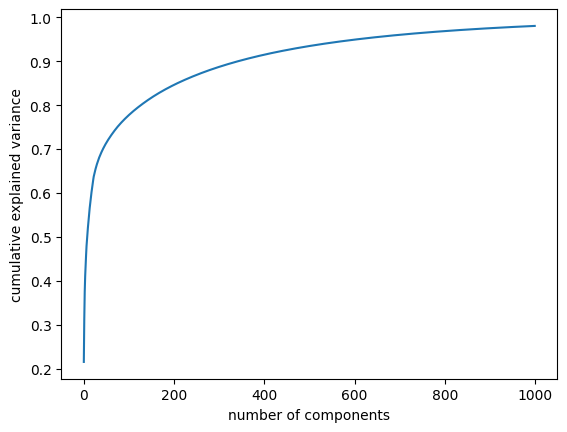

In [ ]:
from sklearn.decomposition import PCA

# Run first to choose best number of principal components
pca = PCA().fit(X_train_flattened_features)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:1000])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)
# Number of components corresponding to explained variance exceeding 0.95
n_components

604

In [ ]:
from sklearn.decomposition import PCA

# Run PCA another time with the computed number of components
pca = PCA(n_components).fit(X_train_flattened_features)

X_train_reduced_features = pca.transform(X_train_flattened_features)
X_eval_reduced_features = pca.transform(X_eval_flattened_features)

print("Shape of the resulting 2D array for train data:", X_train_reduced_features.shape)
print("Shape of the resulting 2D array for eval data:", X_eval_reduced_features.shape)

Shape of the resulting 2D array for train data: (7296, 604)
Shape of the resulting 2D array for eval data: (1824, 604)


## Evaluation Metrics

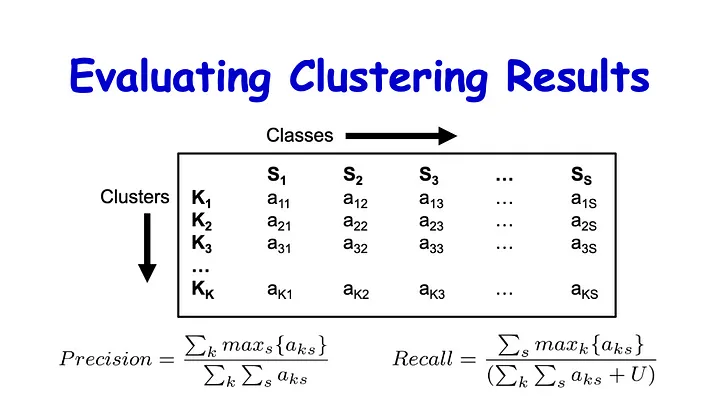

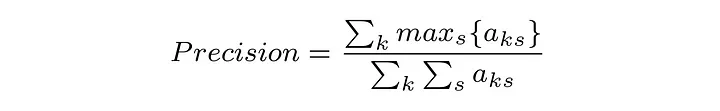

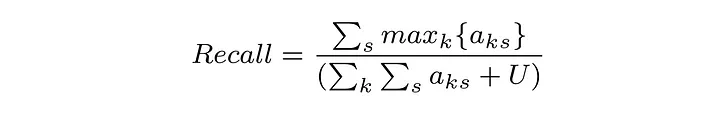

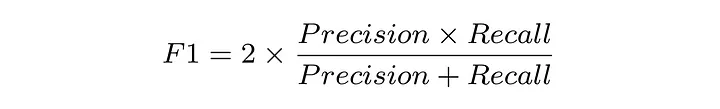

Reference : [Evaluating Clustering Results](https://towardsdatascience.com/evaluating-clustering-results-f13552ee7603)

In [ ]:
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
def get_measures_as_df(y_true, y_pred_per_column, columns):
  measurements = ['precision', 'recall', 'f_measure', 'conditional_entropy']
  measurement_values = {}

  for col, y_pred in zip(columns, y_pred_per_column):
    cont_matrix = contingency_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    conditional_entropy = conditional_entropy_score(y_true, y_pred)
    measurement_values[col] = [precision, recall, f_measure, conditional_entropy]

  df = pd.DataFrame(measurement_values, index=measurements)

  return df

### Precision

In [ ]:
def precision_score(labels_true, labels_pred):
    cont_matrix = contingency_matrix(labels_true, labels_pred)
    return np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)


### Recall

In [ ]:
def recall_score(labels_true, labels_pred):
    cont_matrix = contingency_matrix(labels_true, labels_pred)
    true_positives = np.amax(cont_matrix, axis=1)
    total_positives = np.sum(cont_matrix, axis=0)
    overall_recall = np.sum(true_positives) / np.sum(total_positives)
    return overall_recall


### F1-score

In [ ]:
def f1_score(labels_true, labels_pred):
    p = precision_score(labels_true, labels_pred)
    r = recall_score(labels_true, labels_pred)
    return 2 * p * r / (p + r)

### Conditional Entropy

In [ ]:
def conditional_entropy_score(labels_true, labels_pred):
  cont_matrix = contingency_matrix(labels_true, labels_pred)

  # Convert contingency matrix to joint probability distribution
  joint_distribution = cont_matrix / np.sum(cont_matrix)

  # The probability of each cluster
  prob = np.sum(joint_distribution, axis=0)
  # The entropy of a clustering C
  clustering_entropy = -np.sum(prob * np.log2(prob))

  # Compute joint entropy
  # (joint_distribution == 0) is used to avoid computing the log of zero
  joint_entropy = -np.sum(np.sum(joint_distribution * np.log2(joint_distribution + (joint_distribution == 0)), axis=1))

  # Compute conditional entropy
  conditional_entropy = joint_entropy - clustering_entropy

  return conditional_entropy

## Clustering

This code defines an abstract base class called "Clusterer" using the ABC (Abstract Base Class) module in Python. The "Clusterer" class has two abstract methods: "fit" and "predict" that need to be implemented by its subclasses.

There are three subclasses of "Clusterer" defined: "Kmeans", "NormalizedCut" and "X". Each of these subclasses overrides the "fit" and "predict" methods and provides its own implementation.



In [ ]:
from abc import ABC, abstractmethod


class Clusterer(ABC):

    @abstractmethod
    def fit(self, X):
        """ Compute clusterer clustering.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.

        Returns
        -------
        self : object
            Fitted clusterer.
        """
        pass

    @abstractmethod
    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to predict.

        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        pass


### KMeans

#### Implementation

In [ ]:
class KMeans(Clusterer):
    def __init__(self, n_clusters=8, max_iter=300, n_init=10):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init


    # Computes k-means clustering
    def fit(self, X):
      best_score = -np.inf
      best_labels, best_clusters, best_centroids = None, None, None

      for i in range(self.n_init):
        # run a k-means once
        self._kmeans_single(X)

        # Compute the score of the current assignment
        new_score = self._score()

        if(new_score > best_score):
          best_labels = self.labels
          best_clusters = self.clusters
          best_centroids = self.centroids
          best_score = new_score

      self.labels = best_labels
      self.clusters = best_clusters
      self.centroids = best_centroids

      return self


    # Predict the closest cluster each sample in X belongs to
    def predict(self, X):
      labels = []

      for x in X:
        dists = np.sqrt(np.sum(np.square(x - self.centroids), axis=1))
        j = np.argmin(dists)
        labels.append(j) # Label for the data point x

      labels = np.array(labels)
      return labels


    def _kmeans_single(self, X):
      # Initialize centeroids randomly
      self.centroids = self._init_centroids(X)

      # Iterate, adjusting centroids until converged or until passed max_iter
      iteration = 0
      prev_centroids = None

      while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
        prev_centroids = self.centroids

        # Cluster Assignment Step
        self.clusters, self.labels = self._assign_clusters(X)

        # Centroid Update Step
        self.centroids = self._update_centroids(X)

        iteration += 1


    # Sum of squared errors scoring function
    def _score(self):
      sse = 0

      for i in range(self.n_clusters):
        for x in self.clusters[i]:
          dist = np.sum(np.square(x - self.centroids[i]))
          sse += dist

      return -sse


    # Initialize centroids randomly from the given data points
    def _init_centroids(self, X):
      n_samples = len(X)
      centroids_idx = np.random.choice(n_samples, self.n_clusters, replace=False)
      centroids = X[centroids_idx]
      return centroids


    # Assign each point to the cluster with the closest centroid
    def _assign_clusters(self, X):
      new_clusters = [[] for _ in range(self.n_clusters)]
      new_labels = []

      for x in X:
        dists = np.sqrt(np.sum(np.square(x - self.centroids), axis=1))
        j = np.argmin(dists)
        new_clusters[j].append(x)
        new_labels.append(j) # New label for the data point x

      # Convert to NumPy arrays
      new_clusters = [np.array(cluster) for cluster in new_clusters]
      new_labels = np.array(new_labels)

      return new_clusters, new_labels


    # Update the centroid of each cluster
    def _update_centroids(self, X):
      return np.array([np.mean(cluster, axis=0) if len(cluster) != 0 else self.centroids[i]
                       for i, cluster in enumerate(self.clusters)])


#### Training

In [ ]:
n_clusters = [8, 13, 19, 28, 38]

Run kmeans on training data with mean features:

In [ ]:
y_eval_kmeans_mean = []
y_train_kmeans_mean = []
print('Clusters sizes at different Ks trained on mean features:')
for k in n_clusters:
    kmeans = KMeans(k).fit(X_train_mean_features)
    clusters_sizes = [len(cluster) for cluster in kmeans.clusters]
    print(f'At K = {k}:', clusters_sizes)
    y_train_kmeans_mean.append(kmeans.labels)
    y_eval_kmeans_mean.append(kmeans.predict(X_eval_mean_features))

Clusters sizes at different Ks trained on mean features:
At K = 8: [2911, 1089, 980, 534, 384, 395, 619, 384]
At K = 13: [885, 382, 232, 384, 534, 392, 384, 619, 661, 97, 906, 934, 886]
At K = 19: [363, 382, 117, 471, 307, 375, 96, 379, 584, 192, 406, 832, 349, 226, 801, 269, 97, 290, 760]
At K = 28: [139, 259, 204, 144, 577, 97, 70, 129, 288, 48, 170, 333, 144, 229, 304, 96, 368, 144, 613, 246, 196, 94, 839, 407, 676, 96, 181, 205]
At K = 38: [168, 279, 156, 43, 48, 109, 97, 144, 38, 122, 187, 188, 144, 192, 143, 240, 364, 48, 377, 22, 569, 287, 87, 217, 303, 248, 320, 96, 61, 403, 344, 195, 48, 169, 109, 315, 320, 96]


Run kmeans on training data with flattened then reduced features:

In [ ]:
y_eval_kmeans_flattened = []
y_train_kmeans_flattened = []
print('Clusters sizes at different Ks trained on all (but reduced) features:')
for k in n_clusters:
    kmeans = KMeans(k).fit(X_train_reduced_features)
    clusters_sizes = [len(cluster) for cluster in kmeans.clusters]
    print(f'At K = {k}:', clusters_sizes)
    y_train_kmeans_flattened.append(kmeans.labels)
    y_eval_kmeans_flattened.append(kmeans.predict(X_eval_reduced_features))

Clusters sizes at different Ks trained on all (but reduced) features:
At K = 8: [384, 192, 3115, 796, 731, 1630, 256, 192]
At K = 13: [363, 114, 89, 856, 118, 17, 925, 384, 2729, 30, 101, 1526, 44]
At K = 19: [714, 821, 192, 45, 81, 30, 19, 922, 106, 97, 218, 166, 103, 192, 218, 2292, 222, 91, 767]
At K = 28: [96, 443, 377, 16, 192, 102, 362, 291, 60, 81, 140, 96, 1451, 1057, 29, 37, 353, 97, 56, 698, 1, 67, 44, 64, 237, 217, 257, 375]
At K = 38: [501, 55, 97, 68, 48, 79, 96, 185, 93, 134, 82, 264, 96, 50, 77, 33, 83, 276, 703, 94, 143, 218, 275, 881, 36, 1, 64, 143, 173, 45, 29, 23, 129, 362, 1471, 97, 23, 69]


#### Evaluation

Define ground truth labels:

In [ ]:
num_train_segments = 48
y_true_train = [j for j in range(len(activities)) for i in range(num_train_segments * len(subjects))]
y_true_eval = [j for j in range(len(activities)) for i in range((60 - num_train_segments) * len(subjects))]

print("Training Data - Actual Labels (y_true_train) : ", y_true_train)
print("Evaluation Data - Actual Labels (y_true_eval): ", y_true_eval)

Training Data - Actual Labels (y_true_train) :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Evaluating kmeans on trainig data
print('Evaluating KMeans on training data at different Ks:')
for i, k in enumerate(n_clusters):
  y_pred_train = [y_train_kmeans_mean[i], y_train_kmeans_flattened[i]]
  columns = ['Mean Features', 'Flattened Features']
  measurement_values = get_measures_as_df(y_true_train, y_pred_train, columns)
  print(f'At K = {k}:')
  display(measurement_values)
  print('')

Evaluating KMeans on training data at different Ks:
At K = 8:


,Mean Features,Flattened Features
precision,0.382675,0.312911
recall,0.796327,0.773438
f_measure,0.516937,0.445561
conditional_entropy,2.310641,2.547897



At K = 13:


,Mean Features,Flattened Features
precision,0.441612,0.345121
recall,0.589501,0.788651
f_measure,0.504951,0.480132
conditional_entropy,2.065001,2.337885



At K = 19:


,Mean Features,Flattened Features
precision,0.480537,0.414337
recall,0.503152,0.632127
f_measure,0.491585,0.500569
conditional_entropy,1.938292,2.151492



At K = 28:


,Mean Features,Flattened Features
precision,0.494106,0.505345
recall,0.382675,0.515351
f_measure,0.431310,0.510299
conditional_entropy,1.836603,1.820255



At K = 38:


,Mean Features,Flattened Features
precision,0.591831,0.540159
recall,0.418723,0.482456
f_measure,0.490450,0.509680
conditional_entropy,1.443905,1.722334


In [ ]:
# Evaluating kmeans on evaluation data
print('Evaluating KMeans on evaluation data at different Ks:')
for i, k in enumerate(n_clusters):
  y_pred_train = [y_eval_kmeans_mean[i], y_eval_kmeans_flattened[i]]
  columns = ['Mean Features', 'Flattened Features']
  measurement_values = get_measures_as_df(y_true_eval, y_pred_train, columns)
  print(f'At K = {k}:')
  display(measurement_values)
  print('')

Evaluating KMeans on evaluation data at different Ks:
At K = 8:


,Mean Features,Flattened Features
precision,0.376096,0.305373
recall,0.804825,0.788377
f_measure,0.512637,0.440227
conditional_entropy,2.322882,2.599505



At K = 13:


,Mean Features,Flattened Features
precision,0.440241,0.339912
recall,0.594846,0.799342
f_measure,0.505998,0.476990
conditional_entropy,2.034250,2.364807



At K = 19:


,Mean Features,Flattened Features
precision,0.476425,0.408443
recall,0.486842,0.637061
f_measure,0.481577,0.497756
conditional_entropy,1.888498,2.191901



At K = 28:


,Mean Features,Flattened Features
precision,0.491228,0.483004
recall,0.387610,0.510965
f_measure,0.433310,0.496591
conditional_entropy,1.820105,1.862559



At K = 38:


,Mean Features,Flattened Features
precision,0.600329,0.515351
recall,0.424342,0.475329
f_measure,0.497223,0.494532
conditional_entropy,1.358520,1.779110


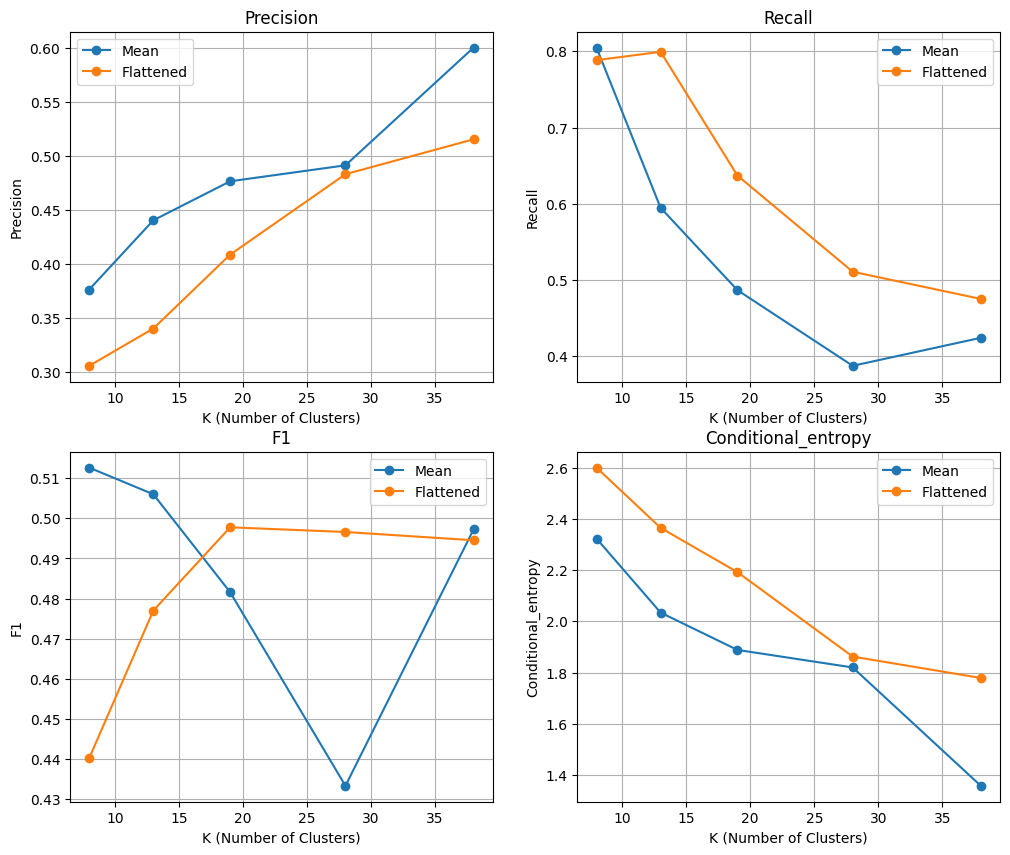

In [ ]:
measurements = ['precision', 'recall', 'f1', 'conditional_entropy']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i, measurement in enumerate(measurements):
  ax = axes[i // 2, i % 2]  # Get the current subplot
  values_mean = []
  values_flattened = []
  score_function = globals()[measurement + '_score']

  for i, k in enumerate(n_clusters):
    values_mean.append(score_function(y_true_eval, y_eval_kmeans_mean[i]))
    values_flattened.append(score_function(y_true_eval, y_eval_kmeans_flattened[i]))

  ax.plot(n_clusters, values_mean, marker='o', label='Mean')
  ax.plot(n_clusters, values_flattened, marker='o', label='Flattened')
  ax.set_title(measurement.capitalize())
  ax.set_xlabel('K (Number of Clusters)')
  ax.set_ylabel(measurement.capitalize())
  ax.legend()
  ax.grid(True)

### Normalized Cut

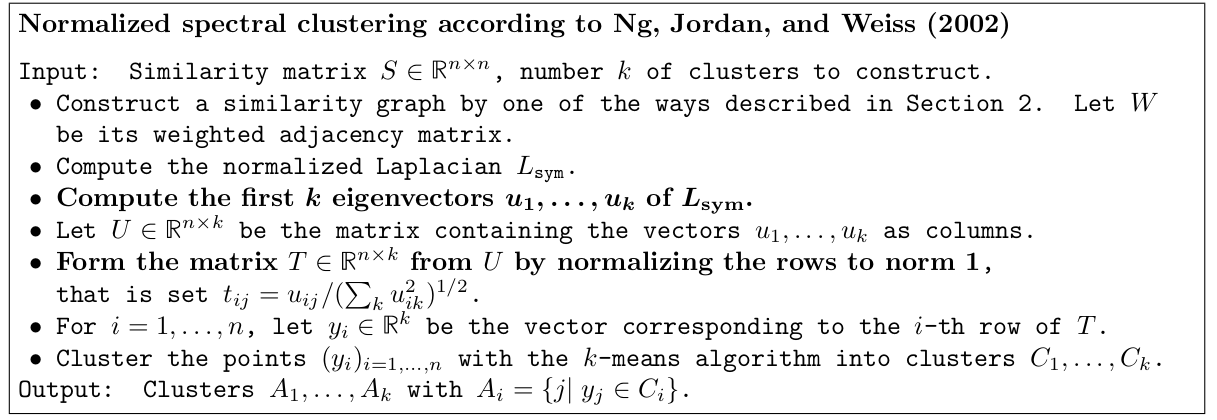

#### Implementation

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster

In [ ]:
class NormalizedCut(Clusterer):
    def __init__(self, n_clusters=8, similarity_func='rbf'):
        self.n_clusters = n_clusters
        self.similarity_func = similarity_func

    def fit(self, X):
        # Compute the similarity matrix based on the specified function
        if self.similarity_func == 'rbf':
            self.W = self._compute_rbf_similarity_matrix(X)
        elif self.similarity_func == 'knn':
            self.W = self._compute_knn_similarity_matrix(X)
        elif self.similarity_func == 'euc':
            self.W = self._compute_euclidean_similarity_matrix(X)
        else:
            raise ValueError("Invalid similarity function. Choose from 'rbf', 'knn', or 'euc'.")

        # Compute the degree matrix
        self.D = np.diag(np.sum(self.W, axis=1))

        # Compute the Laplacian matrix
        self.L = self.D - self.W

        self.La = np.dot(np.linalg.inv(self.D), self.L)

        # Compute the eigenvectors of the Laplacian matrix
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.La)

        # normalize the eigenvectors then use it to cluster the data
        self.labels = self._kmeans(normalize(self.eigenvectors[:, 1:self.n_clusters + 1]))

        return self

    def predict(self, X):
        return self.labels

    def _compute_rbf_similarity_matrix(self, X):
        # Compute the pairwise Euclidean distances manually
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                distances[i, j] = np.sqrt(np.sum((X[i] - X[j]) ** 2))

        # Compute the similarity matrix using RBF kernel
        sigma = np.mean(distances)
        if sigma == 0:
            sigma = 1e-6
        W = np.exp(-distances ** 2 / (2 * sigma ** 2))

        return W


    def _compute_knn_similarity_matrix(self, X, k=5):
        # Compute the pairwise Euclidean distances
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                distances[i, j] = np.sqrt(np.sum((X[i] - X[j]) ** 2))

        # Sort the distances and select the k-nearest neighbors
        sorted_indices = np.argsort(distances, axis=1)
        knn_indices = sorted_indices[:, 1:k+1]

        # Compute the similarity matrix using k-nearest neighbors
        W = np.zeros_like(distances)
        for i in range(len(X)):
            W[i, knn_indices[i]] = 1

        return W

    def _compute_euclidean_similarity_matrix(self, X):
        # Compute the pairwise Euclidean distances
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                distances[i, j] = np.sqrt(np.sum((X[i] - X[j]) ** 2))

        # Compute the similarity matrix using Euclidean distances
        W = np.exp(-distances)

        return W

    def _kmeans(self, X):
        kmeans = cluster.KMeans(n_clusters=self.n_clusters).fit(X)
        return kmeans.predict(X)

#### Training

In [ ]:
n_clusters = 19

ncut = NormalizedCut(n_clusters,"rbf").fit(X_eval_flattened_features)
y_pred_ncut_flattened = ncut.predict(X_eval_flattened_features)

ncut = NormalizedCut(n_clusters,"rbf").fit(X_eval_mean_features)
y_pred_ncut_mean = ncut.predict(X_eval_mean_features)


print("y_pred_ncut_flattened : ",y_pred_ncut_flattened)
print("y_pred_ncut_mean : ",y_pred_ncut_mean)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


y_pred_ncut_flattened :  [ 8  8  8 ... 18  7  7]
y_pred_ncut_mean :  [16 16 16 ... 17 17 17]


#### Evaluation

In [ ]:

ris1 = rand_score(y_true_eval, y_pred_ncut_flattened)
ris2 = rand_score(y_true_eval, y_pred_ncut_mean)

print(ris1, ris2)


amis1 = adjusted_mutual_info_score(y_true_eval, y_pred_ncut_flattened)
amis2 = adjusted_mutual_info_score(y_true_eval, y_pred_ncut_mean)

print(amis1, amis2)

0.9222056615757716 0.9249844819124058
0.533639449270169 0.5431872837628292


### DBSCAN

In [ ]:
from sklearn.metrics import davies_bouldin_score
import time

#### Implementation

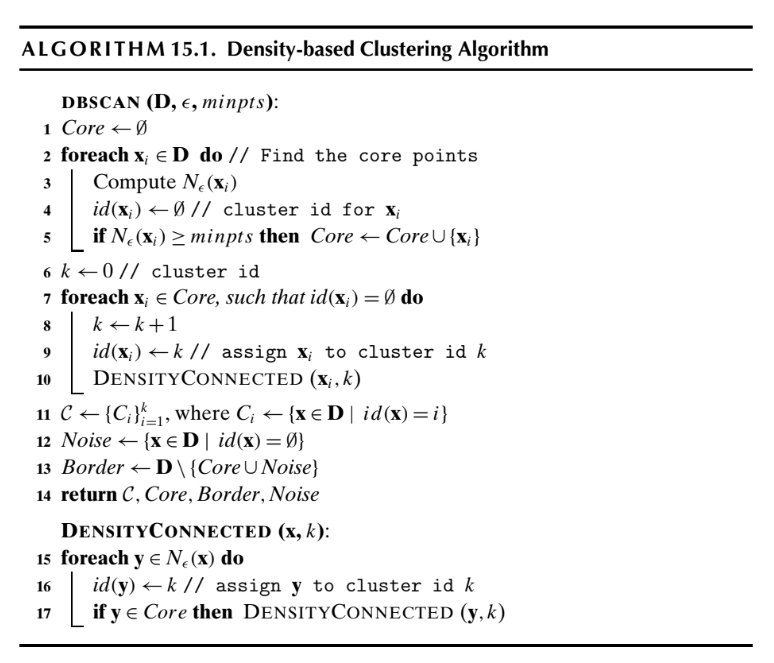

In [ ]:
class DBSCAN (Clusterer):
    def __init__(self, eps=0.1, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X):
        labels = np.full(len(X), -1)

        cluster_id = 0
        for point in range(0, len(X)):

            if labels[point] != -1:
                continue
            self._density_connected(X, labels, point, cluster_id, self.min_samples, self.eps)
            cluster_id += 1

        self.labels = labels
        return self

    def predict(self, X):
        return self.labels

    def _get_neighbors(self, X, point, eps):
        return [i for i, x in enumerate(X) if np.linalg.norm(X[point] - x) <= eps]

    def _density_connected(self, X, labels, point, cluster_id, min_samples, eps):
        stack = [point]
        while stack:
            current_point = stack.pop()

            if labels[current_point] == -1:

                labels[current_point] = cluster_id
                point_neighbors = self._get_neighbors(X, current_point, eps)

                if len(point_neighbors) >= min_samples:
                    stack += point_neighbors

#### Training

Fitting evaluation data with eps = 1.5 and minimum samples = 2

In [ ]:
dbscan = DBSCAN(1.5, 2).fit(X_eval_mean_features)

y_pred_db_mean_features = dbscan.predict(X_eval_mean_features)

Fitting evaluation data with eps = 18 and minimum samples = 2

In [ ]:
dbscan = DBSCAN(18, 2).fit(X_eval_reduced_features)

y_pred_db_reduced_features = dbscan.predict(X_eval_reduced_features)

#### Evaluation

In [ ]:
ris1 = rand_score(y_true_eval, y_pred_db_mean_features)
ris2 = rand_score(y_true_eval, y_pred_db_reduced_features)

amis1 = adjusted_mutual_info_score(y_true_eval, y_pred_db_mean_features)
amis2 = adjusted_mutual_info_score(y_true_eval, y_pred_db_reduced_features)

print("Rand Index Score for DBSCAN with mean features: ", ris1)
print("Rand Index Score for DBSCAN with reduced features: ", ris2)

print("Adjusted Mutual Information Score for DBSCAN with mean features: ", amis1)
print("Adjusted Mutual Information Score for DBSCAN with reduced features: ", amis2)

Rand Index Score for DBSCAN with mean features:  0.95238052275505
Rand Index Score for DBSCAN with reduced features:  0.9494447171136838
Adjusted Mutual Information Score for DBSCAN with mean features:  0.5773121111488918
Adjusted Mutual Information Score for DBSCAN with reduced features:  0.2257667709139499


## Comparison

Evaluation on evaluation data with mean features:

In [ ]:
# Fit KMeans on evaluation data
k = 19
y_pred_kmeans_mean = KMeans(k).fit(X_eval_mean_features).labels
y_pred_kmeans_flattened = KMeans(k).fit(X_eval_reduced_features).labels

In [ ]:
# Evaluating all algorithms on evaluation data
models_labels = [y_pred_kmeans_mean, y_pred_ncut_mean, y_pred_db_mean_features]
print('Evaluating all algorithms on evaluation data with mean features:')
columns = ['KMeans', 'Normalized Cut', 'DBSCAN']
measurement_values = get_measures_as_df(y_true_eval, models_labels, columns)
display(measurement_values)

Evaluating all algorithms on evaluation data with mean features:


,KMeans,Normalized Cut,DBSCAN
precision,0.467654,0.470943,0.970395
recall,0.698465,0.467105,0.130482
f_measure,0.560217,0.469016,0.230034
conditional_entropy,1.984792,1.914493,0.068354


Evaluation on evaluation data with flattened (then reduced) features:

In [ ]:
# Evaluating all algorithms on evaluation data
models_labels = [y_pred_kmeans_flattened, y_pred_ncut_flattened, y_pred_db_reduced_features]
print('Evaluating all algorithms on evaluation data with flattened features:')
columns = ['KMeans', 'Normalized Cut', 'DBSCAN']
measurement_values = get_measures_as_df(y_true_eval, models_labels, columns)
display(measurement_values)

Evaluating all algorithms on evaluation data with flattened features:


,KMeans,Normalized Cut,DBSCAN
precision,0.492873,0.441338,0.996711
recall,0.692434,0.467105,0.043311
f_measure,0.575854,0.453856,0.083015
conditional_entropy,1.926801,1.952597,0.009062


## **Additional:** Hierarchical Clustering Algorithm

### Implementation

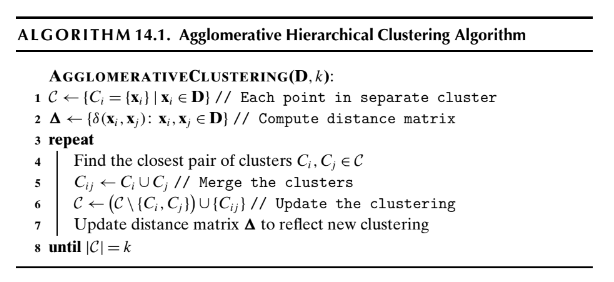

In [ ]:
import numpy as np

#Steps to be memo:
# - Assume all the data points at the first each of them in separate cluster
# - Take the 2 nearest clusters and merge them
# - Now you decreased clutsters by ones
# - LOOP over that till #of_clusters = k
# - How to compute the distance between clusters ?
# - the min distance between all points in the 2 clusters.


class HierarchicalClustering:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples)
        # Initially, each sample is its own cluster
        clusters = [[i] for i in range(n_samples)]
        print(clusters)

        #Here, Must reduce the clusters len by one via merging 2 of them
        #As while loop at each iteration take the most similar 2 clusters and merge them
        while len(clusters) > self.n_clusters:
            min_dist = np.inf
            # Find the closest pair of clusters
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    dist = self._compute_distance(X, clusters[i], clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        closest_clusters = (i, j)

            # Merge the closest pair of clusters
            merged_cluster = clusters[closest_clusters[0]] + clusters[closest_clusters[1]]
            del clusters[closest_clusters[1]]
            del clusters[closest_clusters[0]]
            clusters.append(merged_cluster)

        # Assign cluster labels
        for cluster_label, cluster in enumerate(clusters):
            for sample_index in cluster:
                self.labels_[sample_index] = cluster_label

        return self.labels_

    def _compute_distance(self, X, cluster1, cluster2):
        min_dist = np.inf
        for i in cluster1:
            for j in cluster2:
                dist = np.linalg.norm(X[i] - X[j])
                if dist < min_dist:
                    min_dist = dist
        return min_dist

### Discussion About it

- Main Idea:

  - Hierarchical clustering aims to group similar objects into clusters by building a hierarchy of clusters. Each cluster contains similar objects, and clusters are merged or split based on their similarity, forming a tree-like structure known as a dendrogram.

- Why didn't use it?:

  - Computational Complexity: Hierarchical clustering can be computationally expensive, particularly for large datasets, due to its time complexity.

  - Sensitivity to Distance Metrics: The choice of distance metric significantly affects clustering results. It can be challenging to select an appropriate metric, especially for data with mixed types or non-standard distributions.

- When does it perform well?:

  - Natural Hierarchical Structure: Hierarchical clustering is suitable for data with a natural hierarchical organization.

  - Undefined Number of Clusters: It is useful when the number of clusters is not predefined, as the dendrogram can be cut at various levels to obtain different clusterings.

  - Insightful Visualization: Hierarchical clustering provides a dendrogram that visually represents the clustering process, offering insights into the relationships between data points.

  - It would be more suitable in context of online shopping, Image segmentation and product recommendations.

- Distance Calculation Approaches:
  - Sigle Link: by assume distance between 2 cluster is the minimum distance between any two points in the clusters.
  - Complete Link: assume the distance is the maximum distance between any two points.
  - Mean Distance: assume the distance between any two cluster equals the distance between their means.